In [1]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model

In [2]:
# Loading the DATA
train_data = pd.read_csv("dakshina_dataset_v1.0/kn/lexicons/kn.translit.sampled.train.tsv", sep='\t', header=None)
test_data =  pd.read_csv("dakshina_dataset_v1.0/kn/lexicons/kn.translit.sampled.test.tsv", sep='\t', header = None)
val_data = pd.read_csv("dakshina_dataset_v1.0/kn/lexicons/kn.translit.sampled.dev.tsv", sep='\t', header= None)

In [3]:
# Filtering the data
train_data = train_data.dropna()
test_data = test_data.dropna()
val_data = val_data.dropna()

In [4]:
# Creating Vocubalory
X = [list('\t'+ w +'\n') for w in np.array(train_data[1])] # Input Sequence
Y = [list('\t'+ w +'\n') for w in np.array(train_data[0])] # Traget Sequence

kannada_vocab = set() # Set avoids duplicates
eng_vocab = set() # Set avoids duplicates

for word in X:
    for char in word:
        eng_vocab.add(char)

for word in Y:
    for char in word:
        kannada_vocab.add(char)

kannada_vocab_list = sorted(list(kannada_vocab))
eng_vocab_list = sorted(list(eng_vocab))

In [5]:
# Preparing Data
num_input_tokens = len(eng_vocab_list)
num_output_tokens = len(kannada_vocab_list)

# Mapping character to index
input_token_index = {}
for i, char in enumerate(eng_vocab_list):
    input_token_index[char] = i

output_token_index = {}
for i, char in enumerate(kannada_vocab_list):
    output_token_index[char] = i

# Mapping index to character: 
# Inverting the previous dictionaries to avoid searching operations while decoding

input_index_token = {i: char for char, i in input_token_index.items()}
output_input_token = {i: char for char, i in output_token_index.items()}

max_input_seq_length = max([len(seq) for seq in X])
max_output_seq_length = max([len(seq) for seq in Y])

In [6]:
def prepare(x, y):
    # Converts list of characters -> list of indexes and provides the corresponding teacher forcing targets
    decoder_target = np.zeros((len(x), max_output_seq_length, num_output_tokens), dtype="float32")

    for i, seq in enumerate(y):
        for t, char in enumerate(seq):
            if t > 0 :
                decoder_target[i, t-1, output_token_index[char]] = 1.0
        decoder_target[i, t:, output_token_index["\n"]] = 1.0
    
    encoder_samples = [[input_token_index[letter] for letter in seq] for seq in x]
    decoder_samples = [[output_token_index[letter] for letter in seq] for seq in y]

    return encoder_samples, decoder_samples, decoder_target

In [7]:
X_train = [list('\t'+ w +'\n') for w in np.array(train_data[1])] # Input Sequence
Y_train = [list('\t'+ w +'\n') for w in np.array(train_data[0])] # Traget Sequence

X_test = [list('\t'+ w +'\n') for w in np.array(test_data[1])] # Input Sequence
Y_test = [list('\t'+ w +'\n') for w in np.array(test_data[0])] # Traget Sequence

X_val = [list('\t'+ w +'\n') for w in np.array(val_data[1])] # Input Sequence
Y_val = [list('\t'+ w +'\n') for w in np.array(val_data[0])] # Traget Sequence

In [8]:
encoder_train, decoder_train, decoder_target_train = prepare(X_train, Y_train)
encoder_test, decoder_test, decoder_target_test = prepare(X_test, Y_test)
encoder_val, decoder_val, decoder_target_val = prepare(X_val, Y_val)

In [9]:
def pad(List, max_length):
    return sequence.data_utils.pad_sequences(List, maxlen=max_length, padding="post")

In [10]:
encoder_train = pad(encoder_train, max_input_seq_length)
encoder_test = pad(encoder_test, max_input_seq_length)
encoder_val = pad(encoder_val, max_input_seq_length)

decoder_train = pad(decoder_train, max_output_seq_length)
decoder_test = pad(decoder_test, max_output_seq_length)
decoder_val = pad(decoder_val, max_output_seq_length)

In [11]:
def Eng2Kan(encoder_tokens, decoder_tokens, embedding_dim, hidden_dim, max_input_seq_length, max_output_seq_length,
            no_encoder_layers, no_decoder_layers, dropouts=0.1, cell_type="gru"):

    cell_type = cell_type.lower()  
    
    input_encoder = Input(shape=(None,))
    input_decoder = Input(shape=(None,))
    
    input_embedding = Embedding(encoder_tokens, embedding_dim, input_length=max_input_seq_length)(input_encoder)
    x = input_embedding

    encoder_states = None
    for _ in range(no_encoder_layers):
        if cell_type == "lstm":
            x, memory_state, carry_state = LSTM(hidden_dim, return_state=True, return_sequences=True, 
                                                dropout=dropouts)(x)
            encoder_states = [memory_state, carry_state]
        elif cell_type == "gru":
            x, carry_state = GRU(hidden_dim, return_state=True, return_sequences=True, dropout=dropouts)(x)
            encoder_states = [carry_state]
        else:
            x, carry_state = SimpleRNN(hidden_dim, return_state=True, return_sequences=True, dropout=dropouts)(x)
            encoder_states = [carry_state]

    target_embedding = Embedding(decoder_tokens, embedding_dim, input_length=max_output_seq_length)(input_decoder)

    if cell_type == "lstm":
        decoder_x, _, _ = LSTM(hidden_dim, return_sequences=True, return_state=True,
                               dropout=dropouts)(target_embedding, initial_state=encoder_states)
    elif cell_type == "rnn":
        decoder_x, _ = SimpleRNN(hidden_dim, return_sequences=True, return_state=True,
                                 dropout=dropouts)(target_embedding, initial_state=encoder_states)
    elif cell_type == "gru":
        decoder_x, _ = GRU(hidden_dim, return_sequences=True, return_state=True,
                           dropout=dropouts)(target_embedding, initial_state=encoder_states)

    for _ in range(no_decoder_layers - 1):
        if cell_type == "lstm":
            decoder_x, _, _ = LSTM(hidden_dim, return_sequences=True, return_state=True,
                                   dropout=dropouts)(decoder_x)
        elif cell_type == "rnn":
            decoder_x, _ = SimpleRNN(hidden_dim, return_sequences=True, return_state=True,
                                     dropout=dropouts)(decoder_x)
        elif cell_type == "gru":
            decoder_x, _ = GRU(hidden_dim, return_sequences=True, return_state=True,
                               dropout=dropouts)(decoder_x)

    output = TimeDistributed(Dense(decoder_tokens, activation='softmax'))(decoder_x)

    model = Model([input_encoder, input_decoder], output)

    return model

In [13]:
encoder_tokens = num_input_tokens
decoder_tokens = num_output_tokens

embedding_dim = 32
hidden_dim = 512
no_encoder_layers = 3
no_decoder_layers = 1
dropout = 0.2
cell = "lstm"

In [14]:
model = Eng2Kan(encoder_tokens, decoder_tokens, embedding_dim, hidden_dim, max_input_seq_length, 
                max_output_seq_length, no_decoder_layers, no_decoder_layers, dropouts=dropout,cell_type=cell)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     896         ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     2016        ['input_2[0][0]']                
                                                                                              

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])
batch_size = 32
epochs = 10

In [17]:
class Word_Accuracy(tf.keras.callbacks.Callback):
    def __init__(self, encoder_cv, decoder_cv, inv_target_token_index, max_length_y, sample_size=None):
        super().__init__()
        self.encoder_val = encoder_cv
        self.decoder_val = decoder_cv
        self.inv_target_token_index = inv_target_token_index
        self.max_output_seq_length = max_length_y
        self.sample_size = sample_size  # optional

    def on_epoch_end(self, epoch, logs=None):
        if self.sample_size:
            indices = np.random.choice(len(self.encoder_val), self.sample_size, replace=False)
            enc = self.encoder_val[indices]
            dec = self.decoder_val[indices]
        else:
            enc = self.encoder_val
            dec = self.decoder_val

        predictions = self.model.predict([enc, dec], verbose=0)
        count = 0

        for i in range(len(predictions)):
            actual_out = re.sub(r'\t|\n', '', ''.join(
                [self.inv_target_token_index[dec[i][j]] for j in range(self.max_output_seq_length)]
            ))
            predicted_out = re.sub(r'\t|\n', '', ''.join(
                [self.inv_target_token_index[np.argmax(predictions[i][j])] for j in range(self.max_output_seq_length)]
            ))

            if actual_out == predicted_out:
                count += 1

        acc = count / len(predictions)
        logs["WordAccuracy"] = acc
        print(f"\nEpoch {epoch + 1}: Word-level Accuracy = {acc:.4f}")


In [20]:
word_acc_cb = Word_Accuracy(
    encoder_cv=encoder_val,
    decoder_cv=decoder_val,
    inv_target_token_index=output_input_token,
    max_length_y=max_output_seq_length
)

history = model.fit(
    [encoder_train, decoder_train],
    decoder_target_train,
    batch_size=batch_size,
    epochs=5,
    validation_data=([encoder_val, decoder_val], decoder_target_val),
    callbacks=[word_acc_cb],
    verbose=1
)


Epoch 1/5
1581/1582 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9930
Epoch 1: Word-level Accuracy = 0.3853
1582/1582 [==============================] - 78s 49ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.1657 - val_accuracy: 0.9581 - WordAccuracy: 0.3853
Epoch 2/5
1582/1582 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9939
Epoch 2: Word-level Accuracy = 0.3965
1582/1582 [==============================] - 76s 48ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.1714 - val_accuracy: 0.9591 - WordAccuracy: 0.3965
Epoch 3/5
1581/1582 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9945
Epoch 3: Word-level Accuracy = 0.4082
1582/1582 [==============================] - 77s 49ms/step - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.1672 - val_accuracy: 0.9602 - WordAccuracy: 0.4082
Epoch 4/5
1581/1582 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9949
Epoch 4: Word-level Accu

In [34]:
test_predictions = model.predict([encoder_test, decoder_test], verbose=0)

count = 0
inputs = []
actual_output = []
predicted = []
for i in range(len(test_predictions)):
    
    English_input = re.sub(r'\t|\n', '', ''.join(
        [input_index_token[encoder_test[i][j]] for j in range(max_output_seq_length)]
    )) 
    actual_out = re.sub(r'\t|\n', '', ''.join(
        [output_input_token[decoder_test[i][j]] for j in range(max_output_seq_length)]
    ))
    predicted_out = re.sub(r'\t|\n', '', ''.join(
        [output_input_token[np.argmax(test_predictions[i][j])] for j in range(max_output_seq_length)]
    ))

    actual_output.append(actual_out)
    predicted.append(predicted_out)
    inputs.append(English_input)

    if actual_out == predicted_out:
        count += 1

acc = count / len(test_predictions)
print("Percentage of correct predictions for test dataset is",acc*100)

Percentage of correct predictions for test dataset is 39.61553705905668


In [35]:
# Saving the prediction of the Test data
df = pd.DataFrame({'Input':inputs, 'Target': actual_output, 'Predicted': predicted})

df.to_csv('predictions_vanilla.csv', index=False)

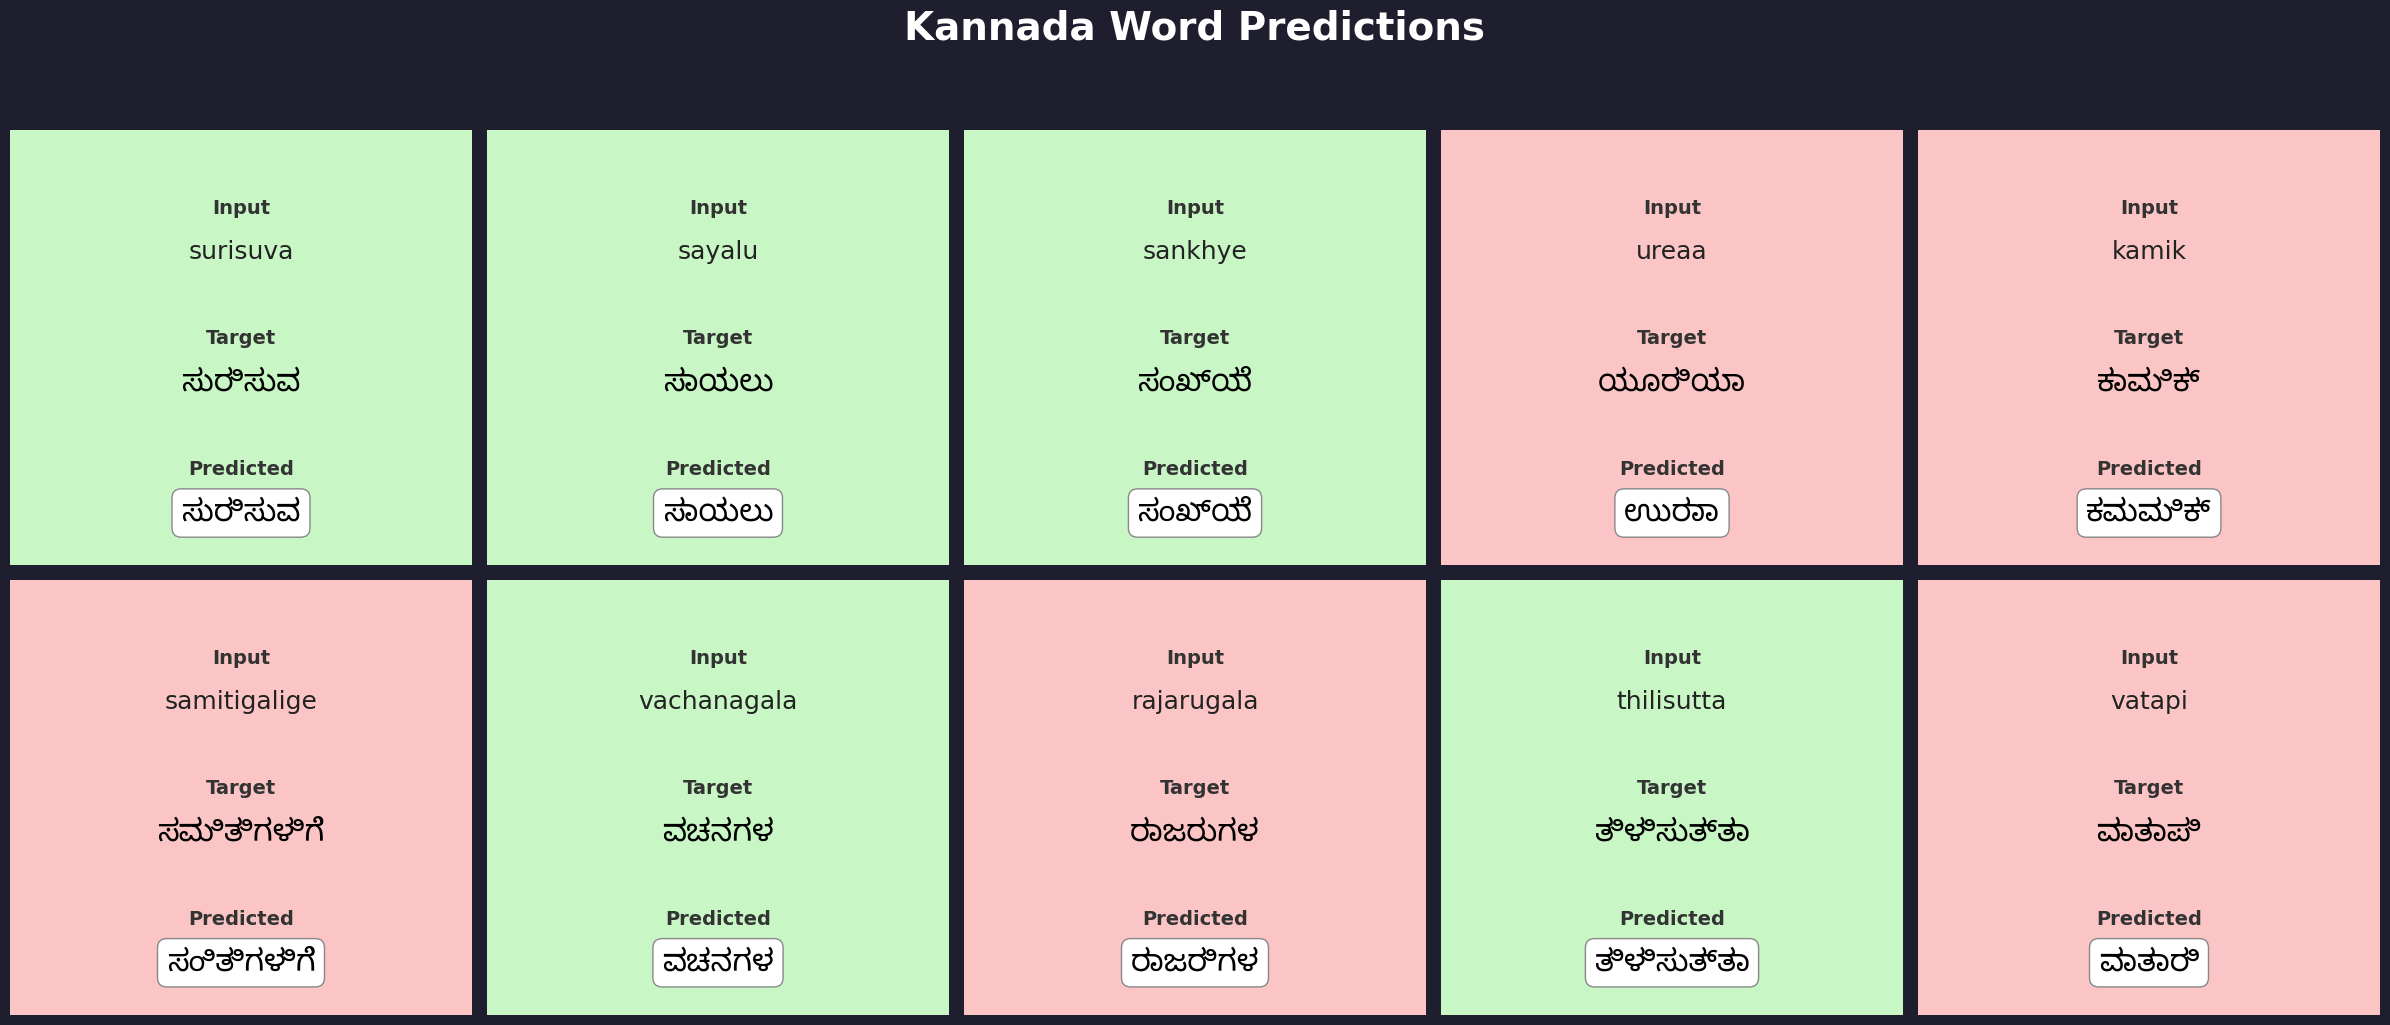

In [65]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, patches

df = pd.read_csv("predictions_vanilla.csv")
df.columns = ["Input", "Target", "Predicted"]
sample_df = df.sample(10, random_state=69).reset_index(drop=True)

kannada_font_path = "Noto_Sans_Kannada/NotoSansKannada-VariableFont_wdth,wght.ttf"
font_prop = font_manager.FontProperties(fname=kannada_font_path)

fig, axs = plt.subplots(2, 5, figsize=(24, 10), facecolor="#1e1e2f")
axs = axs.flatten()

for i, row in sample_df.iterrows():
    ax = axs[i]
    ax.axis("off")
    
    input_text = row["Input"]
    target_text = row["Target"]
    predicted_text = row["Predicted"]
    
    correct = target_text == predicted_text
    box_color = "#c8f7c5" if correct else "#fbc5c5"  # Soft green/red background

    rect = patches.FancyBboxPatch(
        (0, 0), 1, 1,
        boxstyle="round,pad=0.05",
        edgecolor='none',
        facecolor=box_color,
        linewidth=1,
        transform=ax.transAxes,
        zorder=0,
        mutation_scale=0.02
    )
    ax.add_patch(rect)

    # Add texts
    ax.text(0.5, 0.82, f"Input", fontsize=14, ha='center', va='center', fontweight='bold', color="#333333")
    ax.text(0.5, 0.72, input_text, fontsize=18, ha='center', va='center', color="#222222")

    ax.text(0.5, 0.52, "Target", fontsize=14, ha='center', va='center', fontweight='bold', color="#333333")
    ax.text(0.5, 0.42, target_text, fontproperties=font_prop, fontsize=22, ha='center', va='center', color="#000000")

    ax.text(0.5, 0.22, "Predicted", fontsize=14, ha='center', va='center', fontweight='bold', color="#333333")
    ax.text(0.5, 0.12, predicted_text, fontproperties=font_prop, fontsize=22, ha='center', va='center',
            bbox=dict(facecolor="#ffffff", boxstyle="round,pad=0.3", edgecolor='#888888'))

plt.suptitle("Kannada Word Predictions", fontsize=28, color='white', fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()